## Exploratory Data Analysis

**Part-1: Data Overview**
- determine the total number of images in the dataset
- check the image format and size (e.g., resolution, color channels)
- display the images to understand their content and quality
- visualize the distribution of categories/labels
    
**Part-2: Data Cleaning**
- identify any unreadable/missing labels image files and remove/repair them
- (for outliers) analyze the distribution of image sizes to identify outliers
- (for outliers) determine if there are images with unusual properties (e.g., extreme resolutions, high compression)
    
**Part-3: Data Transformation**
- normalize pixel values (e.g., scaling pixel values to a specific range)
- standardize image dimensions (e.g., resize images to a common resolution)
    
**Part-4: Feature Engineering**
- extract common features from images (e.g., color histograms, edge detection)
- use pre-trained models (VGG16) to extract features
- (encoding) convert images into numerical representations

**Part-5: Summary**
- create visualizations to summarize the datasets (e.g., image samples, feature distributions)
- summarize findings from EDA

In [1]:
# import all necessary libraries
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import VGG19_Weights
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Functions
### Part 1 - Data Overview

The data_overview function lists and counts the total number of image files in a specified directory (img_dir). It then displays the first 10 images (or all if fewer than 10) from that directory in a grid layout using Matplotlib. Each image is shown with its filename as the subplot title. Finally, it returns a list of all the image filenames in the directory. This function offers a quick visual summary of the dataset's images.

In [70]:
def data_overview(img_dir):
    img_files = [f for f in os.listdir(img_dir)]
    total_images = len(img_files)
    print("Total images in dataset:", total_images)

    # Display a few images to understand their content and quality
    fig = plt.figure(figsize=(10, 10))
    for i, file in enumerate(img_files[:10], 1):
        ax = fig.add_subplot(5, 5, i)
        img_path = os.path.join(img_dir, file)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(file, fontsize=10)
    
    plt.tight_layout()
    plt.show()

    return img_files

### Part 2 - Data Cleaning

The validify function checks the readability of images in a specified directory (img_dir) based on a list of image filenames (img_files). It attempts to open each image file using PIL (Python Imaging Library) and appends the filenames of readable images to a list called valid_images. If an error occurs while opening an image file, indicating that the image is unreadable or missing, it prints an error message specifying the problematic image file and the encountered exception. Finally, it returns a list of filenames corresponding to the readable images. This function serves to identify and filter out unreadable or missing images from the dataset.

In [3]:
def validify(img_files, img_dir):
    # Identify unreadable/missing images
    valid_images = []
    for file in img_files:
        try:
            img_path = os.path.join(img_dir, file)
            img = Image.open(img_path)
            valid_images.append(file)
        except Exception as e:
            print(f"Error with image {file}: {e}")

    return valid_images

The find_outliers function utilizes the validify function to obtain a list of readable image filenames from a specified directory (img_dir). It then analyzes the distribution of image sizes among the valid images to identify outliers. The function calculates the mean and standard deviation of the image sizes and determines outliers based on a threshold of three standard deviations from the mean. Images whose sizes fall outside this threshold are considered outliers. Finally, the function returns a list of filenames corresponding to the outlier images. This function is useful for detecting and potentially removing images with abnormal sizes from the dataset.

In [4]:
def find_outliers(img_files, img_dir):
    valid_images = validify(img_files, img_dir)
    
    # Analyze the distribution of image sizes to detect outliers
    img_sizes = []
    for file in valid_images:
        img_path = os.path.join(img_dir, file)
        img = Image.open(img_path)
        img_sizes.append(img.size)

    img_size_distribution = np.array(img_sizes)
    img_size_mean = np.mean(img_size_distribution, axis=0)
    img_size_std = np.std(img_size_distribution, axis=0)

    outlier_indices = np.where(
        (img_size_distribution > img_size_mean + 3 * img_size_std) |
        (img_size_distribution < img_size_mean - 3 * img_size_std)
    )

    outlier_imgs = [valid_images[i] for i in outlier_indices[0]]
    return outlier_imgs

The check_image_mode function examines the mode (color mode) of each image file in a specified directory (img_dir). It iterates through the list of image filenames (img_files), attempts to open each image using PIL (Python Imaging Library), and retrieves its mode. If successful, it appends a dictionary containing the filename and its corresponding mode to the img_modes list. In case of an error during image opening, indicating a problem with the image file, it prints an error message specifying the filename and the encountered exception. Finally, the function returns a list of dictionaries, each containing the filename and its mode. This function aids in understanding the color representation of images within the dataset.

In [5]:
def check_image_mode(img_files, img_dir):
    img_modes = []
    for file in img_files:
        img_path = os.path.join(img_dir, file)
        try:
            img = Image.open(img_path)
            img_modes.append({"file": file, "mode": img.mode})
        except Exception as e:
            print(f"Error with image {file}: {e}")

    return img_modes

### Part 3 - Data Transformation

The transformation_def function prepares images from a specified directory (img_dir) for processing by defining a standard set of transformations. These transformations include resizing the images to 224x224 pixels, converting them to PyTorch tensors, and normalizing the pixel values. The function loads each image file as a PIL image and returns both the list of PIL images and the transformation pipeline.

In [6]:
def transformation_def(img_files, img_dir):
    # Define standard image transformations
    # Respective order: standardize dimensions, convert to tensor, normalize pixel values
    img_transform = transforms.Compose([
        # transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    
    img_pil = [Image.open(os.path.join(img_dir, file)) for file in img_files]
    return img_pil, img_transform

The extract_conv_layers function operates on a pretrained VGG19 model to extract convolutional layers and their weights. I chose to use VGG19 for its proven effectiveness in computer vision tasks due to its deep architecture and pretrained weights on large-scale datasets like ImageNet. Its simplicity and interpretability make it suitable for various applications. Leveraging VGG19 allows us to extract meaningful features for further analysis or transfer learning with minimal data.

In [7]:
def extract_conv_layers(pretrained_model):
    conv_weights = []
    conv_layers = []
    # Traverse through the model to extract convolutional layers and weights
    for module in pretrained_model.features.children():
        if isinstance(module, nn.Conv2d):
            conv_weights.append(module.weight)
            conv_layers.append(module)
    return conv_weights, conv_layers

The get_img_tensors function prepares image tensors from a given list of image files in a directory (img_dir). It iterates through each file, opens it as a PIL image, converts it to the RGB color mode, applies the specified image transformation (img_transform), and adds a batch dimension using unsqueeze(0). Finally, it appends the resulting image tensor to a list and returns the list of image tensors. This function is useful for converting image files into a format suitable for deep learning models.

In [8]:
def get_img_tensors(img_files, img_dir, img_transform):
    img_tensors = []
    for file in img_files:
        file = Image.open(os.path.join(img_dir, file)).convert('RGB')
        img_tensor = img_transform(file).unsqueeze(0)
        img_tensors.append(img_tensor)
    return img_tensors

The process_feature_maps function extracts feature maps from a list of image tensors (img_tensors) using a set of convolutional layers (conv_layers). It iterates through each image tensor, passing it through the convolutional layers to extract feature maps. These feature maps are then processed to calculate their mean and converted to NumPy arrays. The processed feature maps and their corresponding layer names are returned.

In [ ]:
def process_feature_maps(img_tensors, conv_layers, device):
    # Extract feature maps for each image
    feature_maps = []
    layer_names = []
    for img_tensor in img_tensors:
        fmap = []
        for layer in conv_layers:
            img_tensor = layer(img_tensor)
            fmap.append(img_tensor)
            layer_names.append(str(layer))
        feature_maps.append(fmap)

    # Process and visualize feature maps
    processed_feature_maps = []
    for fmap in feature_maps:
        processed_fmap = []
        for fm in fmap:
            fm = fm.squeeze(0)
            mean_fm = torch.sum(fm, 0) / fm.shape[0]
            processed_fmap.append(mean_fm.data.cpu().numpy())
        processed_feature_maps.append(processed_fmap)

    return processed_feature_maps, layer_names

This plot_feature_maps function provides a convenient way to visually inspect the learned representations at different layers of a convolutional neural network. It creates a figure with a size of 64x32 and plots the feature maps for the first 5 images. For each image, it adds a subplot and displays the processed feature map. The function also sets the title of each subplot to the corresponding layer name.

In [10]:
def plot_feature_maps(processed_feature_maps, layer_names):
    # Plot the feature maps
    fig = plt.figure(figsize=(64,32))
    for i in range(min(5, len(processed_feature_maps))):  # Plot feature maps for the first 5 images
        ax = fig.add_subplot(1, 5, i+1)
        ax.imshow(processed_feature_maps[i])
        ax.axis("off")
        ax.set_title(layer_names[i].split('(')[0], fontsize=32)

### Part 4 - Feature Engineering

The feature_stats function computes statistics for the processed feature maps. It takes as input the processed feature maps (processed_feature_maps) and a list of valid image filenames (valid_images). For each image, it iterates through its corresponding list of feature maps and calculates statistics such as mean, standard deviation, maximum, and minimum values. These statistics are stored in dictionaries along with the filename and appended to a list. Finally, the function returns a list of feature statistics for all images in the dataset. This function is useful for analyzing the distribution of features extracted from convolutional neural networks across different images.

In [13]:
def feature_stats(processed_feature_maps, valid_images):
    flattened_features = [fm.flatten() for fm in processed_feature_maps]
    feature_stats_list = []
    for file, fmap_list in zip(valid_images, processed_feature_maps):
        feature_stats = []
        for fm in fmap_list:
            stats = {
                "file": file,
                "mean": np.mean(fm),
                "std": np.std(fm),
                "max": np.max(fm),
                "min": np.min(fm),
            }
            feature_stats.append(stats)

        feature_stats_list.append(feature_stats)

    return feature_stats_list

The activation_strengths function calculates the activation strengths for each image in the dataset. It takes as input the convolutional layers (conv_layers), a list of image tensors (img_tensors), and the corresponding valid image filenames (valid_images). For each image, it iterates through the convolutional layers, applies them to the image tensor, and computes the feature maps. Then, it calculates the activation strength by summing the absolute values of all elements in the feature maps. Finally, the function returns a list of dictionaries containing the filename and its corresponding activation strength for each image. This function is valuable for assessing the overall activation levels of different images in the dataset.

In [14]:
def activation_strengths(conv_layers, img_tensors, valid_images):
    activation_strengths_list = []

    for file, img_tensor in zip(valid_images, img_tensors):
        feature_maps = []
        for layer in conv_layers:
            img_tensor = layer(img_tensor)
            feature_maps.append(img_tensor)

        # Calculate activation strengths
        activation_strengths = sum([torch.sum(torch.abs(fm)).item() for fm in feature_maps])

        activation_strengths_list.append({
            "file": file,
            "activation_strength": activation_strengths,
        })

    return activation_strengths_list

### Part 5 - Summary

In [15]:
def summary(feature_stats_list, activation_strengths_list):
    # Display activation strengths summary
    activation_strengths_df = pd.DataFrame(activation_strengths_list)

    plt.figure(figsize=(10, 6))
    plt.plot(activation_strengths_df['activation_strength'], label='Activation Strength')
    plt.xlabel('Image Index')
    plt.ylabel('Strength')
    plt.title('Activation Strengths for Each Image')
    plt.show()

    # Display feature statistics summary
    feature_stats_df = pd.DataFrame(feature_stats_list)

    print("Feature Statistics Summary:")
    print(feature_stats_df)

    print("Activation Strengths Summary:")
    print(activation_strengths_df)

## Actual Data Analysis
### ./data/original/Testing/glioma/ 

Total images in dataset: 1321


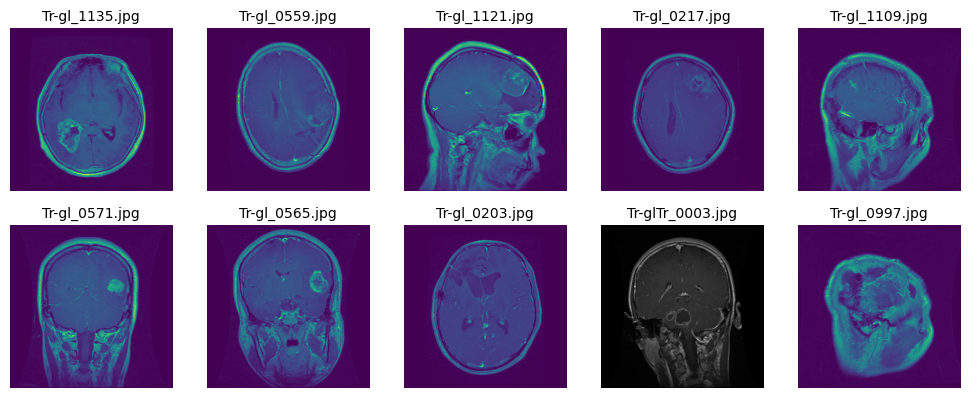

In [16]:
# Directory: ./Testing/glioma images
tr_glioma_dir = "./data/original/Training/glioma/"
tr_glioma_files = data_overview(tr_glioma_dir)

Gliomas are tumors that arise from glial cells, which are supportive cells in the brain. On imaging scans, gliomas typically appear as irregular, infiltrative lesions with indistinct borders. This is understood through these images as the outlines around the white tumors are a bit blurry, as they lead to swelling due to their invasive nature.

In [17]:
tr_glioma_modes = check_image_mode(tr_glioma_files, tr_glioma_dir)
tr_glioma_rgb_images = [img["file"] for img in tr_glioma_modes if img["mode"] == "RGB"]
print(tr_glioma_rgb_images)

['Tr-glTr_0003.jpg', 'Tr-gl_0029.jpg', 'Tr-gl_0015.jpg', 'Tr-gl_0014.jpg', 'Tr-gl_0028.jpg', 'Tr-glTr_0002.jpg', 'Tr-glTr_0000.jpg', 'Tr-gl_0016.jpg', 'Tr-gl_0017.jpg', 'Tr-glTr_0001.jpg', 'Tr-glTr_0005.jpg', 'Tr-gl_0013.jpg', 'Tr-gl_0012.jpg', 'Tr-glTr_0004.jpg', 'Tr-glTr_0006.jpg', 'Tr-gl_0010.jpg', 'Tr-gl_0038.jpg', 'Tr-gl_0039.jpg', 'Tr-gl_0011.jpg', 'Tr-glTr_0007.jpg', 'Tr-gl_0076.jpg', 'Tr-gl_0062.jpg', 'Tr-gl_0089.jpg', 'Tr-gl_0102.jpg', 'Tr-gl_0116.jpg', 'Tr-gl_0117.jpg', 'Tr-gl_0103.jpg', 'Tr-gl_0088.jpg', 'Tr-gl_0063.jpg', 'Tr-gl_0077.jpg', 'Tr-gl_0049.jpg', 'Tr-gl_0061.jpg', 'Tr-gl_0075.jpg', 'Tr-gl_0115.jpg', 'Tr-gl_0101.jpg', 'Tr-gl_0100.jpg', 'Tr-gl_0114.jpg', 'Tr-gl_0074.jpg', 'Tr-gl_0060.jpg', 'Tr-gl_0048.jpg', 'Tr-gl_0064.jpg', 'Tr-gl_0070.jpg', 'Tr-gl_0058.jpg', 'Tr-gl_0110.jpg', 'Tr-gl_0104.jpg', 'Tr-gl_0105.jpg', 'Tr-gl_0111.jpg', 'Tr-gl_0059.jpg', 'Tr-gl_0071.jpg', 'Tr-gl_0065.jpg', 'Tr-gl_0073.jpg', 'Tr-gl_0067.jpg', 'Tr-gl_0098.jpg', 'Tr-gl_0107.jpg', 'Tr-gl_0113

In [18]:
tr_glioma_grayscale_images = [img["file"] for img in tr_glioma_modes if img["mode"] != "RGB"]
print(tr_glioma_grayscale_images)

['Tr-gl_1135.jpg', 'Tr-gl_0559.jpg', 'Tr-gl_1121.jpg', 'Tr-gl_0217.jpg', 'Tr-gl_1109.jpg', 'Tr-gl_0571.jpg', 'Tr-gl_0565.jpg', 'Tr-gl_0203.jpg', 'Tr-gl_0997.jpg', 'Tr-gl_0983.jpg', 'Tr-gl_0773.jpg', 'Tr-gl_0767.jpg', 'Tr-gl_0954.jpg', 'Tr-gl_0940.jpg', 'Tr-gl_0798.jpg', 'Tr-gl_0968.jpg', 'Tr-gl_1243.jpg', 'Tr-gl_0149.jpg', 'Tr-gl_1257.jpg', 'Tr-gl_0607.jpg', 'Tr-gl_0161.jpg', 'Tr-gl_0175.jpg', 'Tr-gl_0613.jpg', 'Tr-gl_0820.jpg', 'Tr-gl_1280.jpg', 'Tr-gl_1294.jpg', 'Tr-gl_0834.jpg', 'Tr-gl_0808.jpg', 'Tr-gl_1041.jpg', 'Tr-gl_0439.jpg', 'Tr-gl_1055.jpg', 'Tr-gl_0363.jpg', 'Tr-gl_0405.jpg', 'Tr-gl_0411.jpg', 'Tr-gl_1069.jpg', 'Tr-gl_0377.jpg', 'Tr-gl_1082.jpg', 'Tr-gl_0388.jpg', 'Tr-gl_1096.jpg', 'Tr-gl_1097.jpg', 'Tr-gl_0389.jpg', 'Tr-gl_1083.jpg', 'Tr-gl_0410.jpg', 'Tr-gl_0376.jpg', 'Tr-gl_1068.jpg', 'Tr-gl_0362.jpg', 'Tr-gl_0404.jpg', 'Tr-gl_1054.jpg', 'Tr-gl_1040.jpg', 'Tr-gl_0438.jpg', 'Tr-gl_0809.jpg', 'Tr-gl_1295.jpg', 'Tr-gl_0835.jpg', 'Tr-gl_0821.jpg', 'Tr-gl_1281.jpg', 'Tr-gl_01

In [19]:
tr_glioma_valid_imgs = validify(tr_glioma_files, tr_glioma_dir)
tr_glioma_outliers = find_outliers(tr_glioma_files, tr_glioma_dir)
print("Outliers based on size:", tr_glioma_outliers)

Outliers based on size: []


In [20]:
# Load pre-trained VGG16 model
pretrained_model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model = pretrained_model.to(device)

In [21]:
tr_glioma_img_pil, tr_glioma_img_transform = transformation_def(tr_glioma_files, tr_glioma_dir)
tr_glioma_img_pil

[<PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFil

In [22]:
tr_glioma_img_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

In [23]:
# Extract convolutional layers from the model
tr_glioma_conv_weights, tr_glioma_conv_layers = extract_conv_layers(pretrained_model)
tr_glioma_conv_weights

[Parameter containing:
 tensor([[[[-5.3474e-02, -4.9257e-02, -6.7942e-02],
           [ 1.5314e-02,  4.5068e-02,  2.1444e-03],
           [ 3.6226e-02,  1.9999e-02,  1.9864e-02]],
 
          [[ 1.7015e-02,  5.5403e-02, -6.2293e-03],
           [ 1.4165e-01,  2.2705e-01,  1.3758e-01],
           [ 1.2000e-01,  2.0030e-01,  9.2114e-02]],
 
          [[-4.4885e-02,  1.2680e-02, -1.4497e-02],
           [ 5.9742e-02,  1.3955e-01,  5.4102e-02],
           [-9.6141e-04,  5.8304e-02, -2.9663e-02]]],
 
 
         [[[ 2.6072e-01, -3.0489e-01, -5.0152e-01],
           [ 4.1376e-01, -2.0831e-01, -4.9086e-01],
           [ 5.8770e-01,  4.2851e-01, -1.3850e-01]],
 
          [[ 2.8746e-01, -3.3338e-01, -4.5564e-01],
           [ 3.7836e-01, -2.9144e-01, -4.9720e-01],
           [ 5.4778e-01,  4.8983e-01, -1.7166e-01]],
 
          [[ 6.7260e-02, -9.5386e-02, -3.8037e-02],
           [ 6.1955e-02, -1.3125e-01, -1.0691e-01],
           [ 4.8107e-02,  2.2999e-01, -3.0578e-02]]],
 
 
         [[[-3.24

In [24]:
 tr_glioma_conv_layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(512, 512, kernel_s

In [25]:
tr_glioma_img_tensors = get_img_tensors(tr_glioma_files, tr_glioma_dir, tr_glioma_img_transform)
tr_glioma_img_tensors

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]]]),
 tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           

<span style="color:red">**Please Note: I have commented the image processing commands below out because my computer doesn't have enough memory to handle all of the rendering. It also takes over 2 hours for every 100 images (which are 224 by 224 pixels), which means all 7k images from my dataset will take days to run. The other folders (e.g. meningioma, notumor, and pituitary) have the same issue.**</span>

## Please look at ./feature map testing.ipynb to see how all images should be processed and how features are extracted if the functions were run on all the files

In [26]:
# Extract and process feature maps for the sample image
# tr_glioma_processed_feature_maps, tr_glioma_layer_names = process_feature_maps(tr_glioma_img_tensors, tr_glioma_conv_layers, device)
# tr_glioma_processed_feature_maps

In [27]:
# tr_glioma_layer_names

In [28]:
# Plot the feature maps of the first 5 images
# plot_feature_maps(processed_feature_maps, layer_names)
# plt.show()

In [29]:
# tr_glioma_feature_stats_list = feature_stats(processed_feature_maps, valid_imgs)
# tr_glioma_feature_stats

In [30]:
# tr_glioma_activation_strengths_list = activation_strengths(conv_layers, img_tensors, valid_imgs)
# tr_glioma_activation_strengths_list

In [31]:
# tr_glioma_summary_plot = summary(feature_stats_list, activation_strengths_list)
# tr_glioma_summary_plot

### ./data/original/Training/meningioma

Total images in dataset: 1339


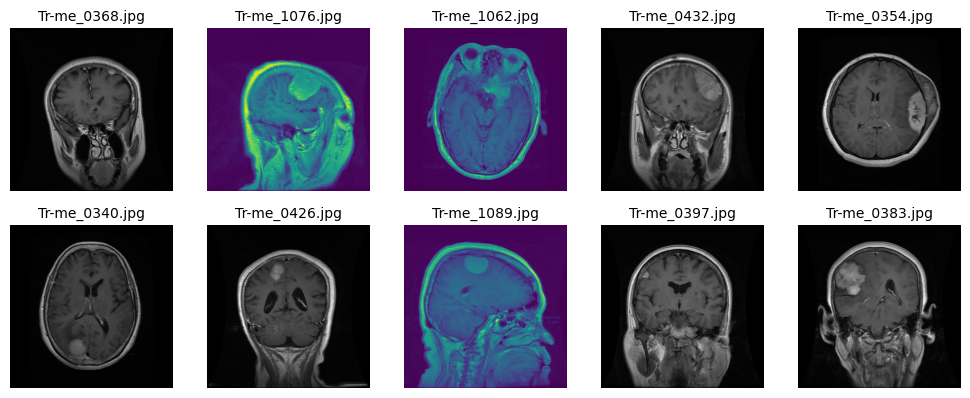

In [39]:
# Directory: ./Testing/meningioma images
tr_meningioma_dir = "./data/original/Training/meningioma/"
tr_meningioma_files = data_overview(tr_meningioma_dir)

Meningiomas originate from the meninges, the protective membranes surrounding the brain and spinal cord. These tumors often appear as well-defined, rounded masses attached to the dura mater (outermost meningeal layer) on imaging scans. The also are commonly located at the vonexity of the brain of around the skull, which we see in our previewed images -- they are all very close to the surrounding skeletal wall.

In [40]:
tr_meningioma_modes = check_image_mode(tr_meningioma_files, tr_meningioma_dir)
tr_meningioma_rgb_images = [img["file"] for img in tr_meningioma_modes if img["mode"] == "RGB"]
print(tr_meningioma_rgb_images)

['Tr-me_0368.jpg', 'Tr-me_0432.jpg', 'Tr-me_0354.jpg', 'Tr-me_0340.jpg', 'Tr-me_0426.jpg', 'Tr-me_0397.jpg', 'Tr-me_0383.jpg', 'Tr-me_0618.jpg', 'Tr-me_0156.jpg', 'Tr-me_0630.jpg', 'Tr-me_0624.jpg', 'Tr-me_0142.jpg', 'Tr-me_0195.jpg', 'Tr-me_0181.jpg', 'Tr-me_0778.jpg', 'Tr-me_0022.jpg', 'Tr-me_0744.jpg', 'Tr-me_0750.jpg', 'Tr-me_0036.jpg', 'Tr-me_0787.jpg', 'Tr-me_0208.jpg', 'Tr-me_0546.jpg', 'Tr-me_0220.jpg', 'Tr-me_0234.jpg', 'Tr-me_0552.jpg', 'Tr-me_0585.jpg', 'Tr-me_0591.jpg', 'Tr-me_0590.jpg', 'Tr-me_0584.jpg', 'Tr-me_0235.jpg', 'Tr-me_0553.jpg', 'Tr-me_0547.jpg', 'Tr-me_0221.jpg', 'Tr-me_0209.jpg', 'Tr-me_0786.jpg', 'Tr-me_0751.jpg', 'Tr-me_0037.jpg', 'Tr-me_0023.jpg', 'Tr-me_0745.jpg', 'Tr-me_0779.jpg', 'Tr-me_0180.jpg', 'Tr-me_0194.jpg', 'Tr-me_0625.jpg', 'Tr-me_0143.jpg', 'Tr-me_0157.jpg', 'Tr-me_0631.jpg', 'Tr-me_0619.jpg', 'Tr-me_0382.jpg', 'Tr-me_0396.jpg', 'Tr-me_0341.jpg', 'Tr-me_0427.jpg', 'Tr-me_0433.jpg', 'Tr-me_0355.jpg', 'Tr-me_0369.jpg', 'Tr-me_0419.jpg', 'Tr-me_04

In [41]:
tr_meningioma_grayscale_images = [img["file"] for img in tr_meningioma_modes if img["mode"] != "RGB"]
print(tr_meningioma_grayscale_images)

['Tr-me_1076.jpg', 'Tr-me_1062.jpg', 'Tr-me_1089.jpg', 'Tr-me_1274.jpg', 'Tr-me_1260.jpg', 'Tr-me_1248.jpg', 'Tr-me_0817.jpg', 'Tr-me_0803.jpg', 'Tr-me_1300.jpg', 'Tr-me_1314.jpg', 'Tr-me_0988.jpg', 'Tr-me_1328.jpg', 'Tr-me_0963.jpg', 'Tr-me_0977.jpg', 'Tr-me_0793.jpg', 'Tr-me_1102.jpg', 'Tr-me_1116.jpg', 'Tr-me_1117.jpg', 'Tr-me_1103.jpg', 'Tr-me_0792.jpg', 'Tr-me_0976.jpg', 'Tr-me_0962.jpg', 'Tr-me_0989.jpg', 'Tr-me_1329.jpg', 'Tr-me_1315.jpg', 'Tr-me_1301.jpg', 'Tr-me_0802.jpg', 'Tr-me_0816.jpg', 'Tr-me_1249.jpg', 'Tr-me_1261.jpg', 'Tr-me_1275.jpg', 'Tr-me_1088.jpg', 'Tr-me_1063.jpg', 'Tr-me_1077.jpg', 'Tr-me_1061.jpg', 'Tr-me_1075.jpg', 'Tr-me_1049.jpg', 'Tr-me_1263.jpg', 'Tr-me_1277.jpg', 'Tr-me_0800.jpg', 'Tr-me_0814.jpg', 'Tr-me_0828.jpg', 'Tr-me_1288.jpg', 'Tr-me_1317.jpg', 'Tr-me_1303.jpg', 'Tr-me_0974.jpg', 'Tr-me_0960.jpg', 'Tr-me_0948.jpg', 'Tr-me_1115.jpg', 'Tr-me_1101.jpg', 'Tr-me_1129.jpg', 'Tr-me_1128.jpg', 'Tr-me_1100.jpg', 'Tr-me_1114.jpg', 'Tr-me_0949.jpg', 'Tr-me_07

In [42]:
tr_meningioma_valid_imgs = validify(tr_meningioma_files, tr_meningioma_dir)
tr_meningioma_outliers = find_outliers(tr_meningioma_files, tr_meningioma_dir)
print("Outliers based on size:", tr_meningioma_outliers)

Outliers based on size: ['Tr-me_0195.jpg', 'Tr-me_0195.jpg', 'Tr-me_0585.jpg', 'Tr-me_0585.jpg', 'Tr-me_0591.jpg', 'Tr-me_0235.jpg', 'Tr-me_0235.jpg', 'Tr-me_0357.jpg', 'Tr-me_0357.jpg', 'Tr-me_0196.jpg', 'Tr-me_0223.jpg', 'Tr-me_0223.jpg', 'Tr-me_0592.jpg', 'Tr-me_0586.jpg', 'Tr-me_0586.jpg', 'Tr-me_0587.jpg', 'Tr-me_0587.jpg', 'Tr-me_0236.jpg', 'Tr-me_0236.jpg', 'Tr-me_0197.jpg', 'Tr-me_0346.jpg', 'Tr-me_0346.jpg', 'Tr-me_0186.jpg', 'Tr-me_0580.jpg', 'Tr-me_0580.jpg', 'Tr-me_0594.jpg', 'Tr-me_0581.jpg', 'Tr-me_0581.jpg', 'Tr-me_0218.jpg', 'Tr-me_0218.jpg', 'Tr-me_0185.jpg', 'Tr-me_0185.jpg', 'Tr-me_0243.jpg', 'Tr-me_0243.jpg', 'Tr-me_0257.jpg', 'Tr-me_0257.jpg', 'Tr-me_0281.jpg', 'Tr-me_0281.jpg', 'Tr-me_0242.jpg', 'Tr-me_0242.jpg', 'Tr-me_0268.jpg', 'Tr-me_0268.jpg', 'Tr-me_0283.jpg', 'Tr-me_0283.jpg', 'Tr-me_0282.jpg', 'Tr-me_0282.jpg', 'Tr-me_0241.jpg', 'Tr-me_0241.jpg', 'Tr-me_0335.jpg', 'Tr-me_0335.jpg', 'Tr-me_0245.jpg', 'Tr-me_0279.jpg', 'Tr-me_0279.jpg', 'Tr-me_0292.jpg', 'Tr

In [45]:
tr_meningioma_files = [file for file in tr_meningioma_files if file not in tr_meningioma_outliers]
len(tr_meningioma_files)

1270

We identified by comparing the dimensions (e.g., height, width) or aspect ratio of images to a predefined threshold or criteria. As such, we removed these outliers from the training meningioma dataset, reducing the number of images from 1339 to 1270. This is a critical step in preprocessing image datasets to ensure their integrity and suitability for analysis or modeling.

In [46]:
tr_meningioma_img_pil, tr_meningioma_img_transform = transformation_def(tr_meningioma_files, tr_meningioma_dir)
tr_meningioma_img_pil

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 <PIL.JpegImagePlugin.

In [48]:
# Extract convolutional layers from the model -- should be the same throughout
tr_meningioma_conv_weights, tr_meningioma_conv_layers = extract_conv_layers(pretrained_model)

In [49]:
tr_meningioma_img_tensors = get_img_tensors(tr_meningioma_files, tr_meningioma_dir, tr_meningioma_img_transform)
tr_meningioma_img_tensors

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]]]),
 tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           

### ./data/original/Training/notumor

Total images in dataset: 1595


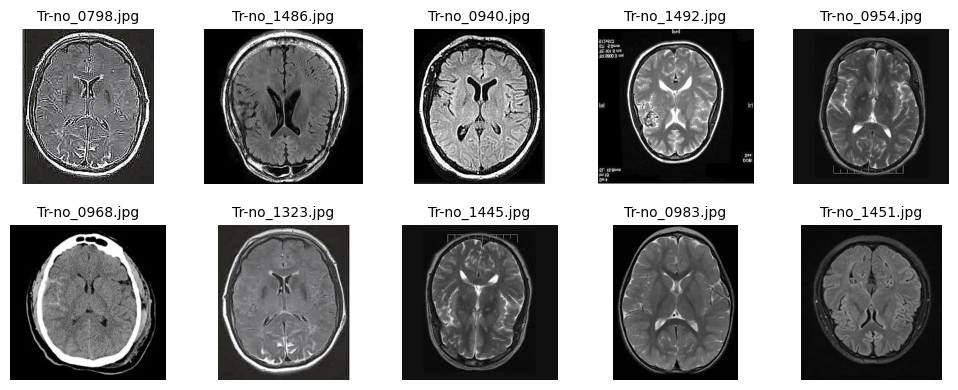

In [52]:
# Directory: ./data/original/Training images
tr_notumor_dir = "./data/original/Training/notumor/"
tr_notumor_files = data_overview(tr_notumor_dir)

These do not show evidence of a brain tumor; the imaging scans depict normal brain structures without any abnormal masses or lesions.

In [53]:
tr_notumor_modes = check_image_mode(tr_notumor_files, tr_notumor_dir)
tr_notumor_rgb_images = [img["file"] for img in tr_notumor_modes if img["mode"] == "RGB"]
print(tr_notumor_rgb_images)

['Tr-no_0798.jpg', 'Tr-no_1486.jpg', 'Tr-no_0940.jpg', 'Tr-no_1492.jpg', 'Tr-no_0954.jpg', 'Tr-no_0968.jpg', 'Tr-no_1323.jpg', 'Tr-no_1445.jpg', 'Tr-no_0983.jpg', 'Tr-no_1451.jpg', 'Tr-no_0997.jpg', 'Tr-no_0029.jpg', 'Tr-no_1337.jpg', 'Tr-no_1479.jpg', 'Tr-no_0767.jpg', 'Tr-no_0773.jpg', 'Tr-no_0015.jpg', 'Tr-no_0559.jpg', 'Tr-no_1121.jpg', 'Tr-no_1135.jpg', 'Tr-no_0565.jpg', 'Tr-no_0203.jpg', 'Tr-no_1109.jpg', 'Tr-no_0217.jpg', 'Tr-no_0571.jpg', 'Tr-no_1096.jpg', 'Tr-no_0388.jpg', 'Tr-no_1082.jpg', 'Tr-no_1055.jpg', 'Tr-no_1041.jpg', 'Tr-no_0439.jpg', 'Tr-no_0411.jpg', 'Tr-no_0377.jpg', 'Tr-no_1069.jpg', 'Tr-no_0363.jpg', 'Tr-no_0405.jpg', 'Tr-no_1294.jpg', 'Tr-no_0834.jpg', 'Tr-no_0820.jpg', 'Tr-no_1280.jpg', 'Tr-no_0808.jpg', 'Tr-no_1257.jpg', 'Tr-no_0149.jpg', 'Tr-no_1531.jpg', 'Tr-no_1525.jpg', 'Tr-no_1243.jpg', 'Tr-no_0175.jpg', 'Tr-no_0613.jpg', 'Tr-no_0607.jpg', 'Tr-no_1519.jpg', 'Tr-no_0161.jpg', 'Tr-no_1518.jpg', 'Tr-no_0606.jpg', 'Tr-no_0160.jpg', 'Tr-no_0174.jpg', 'Tr-no_06

In [54]:
tr_notumor_grayscale_images = [img["file"] for img in tr_notumor_modes if img["mode"] != "RGB"]
print(tr_notumor_grayscale_images)

['Tr-no_0996.jpg', 'Tr-no_0991.jpg', 'Tr-no_1287.jpg', 'Tr-no_1087.jpg', 'Tr-no_0616.jpg', 'Tr-no_1534.jpg', 'Tr-no_1247.jpg', 'Tr-no_0987.jpg', 'Tr-no_1143.jpg', 'Tr-no_1020.jpg', 'Tr-no_1430.jpg', 'Tr-no_1568.jpg', 'Tr-no_1019.jpg', 'Tr-no_1014.jpg', 'Tr-no_0690.jpg', 'Tr-no_1001.jpg', 'Tr-no_1011.jpg', 'Tr-no_1575.jpg', 'Tr-no_0708.jpg', 'Tr-no_1012.jpg', 'Tr-no_0654.jpg', 'Tr-no_1007.jpg', 'Tr-no_1198.jpg', 'Tr-no_0961.jpg', 'Tr-no_1276.jpg', 'Tr-no_0621.jpg', 'Tr-no_1463.jpg', 'Tr-no_1449.jpg', 'Tr-no_1298.jpg', 'Tr-no_1501.jpg', 'Tr-no_0965.jpg']


In [55]:
tr_notumor_valid_imgs = validify(tr_notumor_files, tr_notumor_dir)
tr_notumor_outliers = find_outliers(tr_notumor_files, tr_notumor_dir)
print("Outliers based on size:", tr_notumor_outliers)

Outliers based on size: ['Tr-no_1135.jpg', 'Tr-no_0174.jpg', 'Tr-no_0996.jpg', 'Tr-no_0996.jpg', 'Tr-no_0200.jpg', 'Tr-no_0189.jpg', 'Tr-no_1127.jpg', 'Tr-no_1127.jpg', 'Tr-no_0239.jpg', 'Tr-no_0198.jpg', 'Tr-no_1142.jpg', 'Tr-no_1142.jpg', 'Tr-no_0261.jpg', 'Tr-no_0261.jpg', 'Tr-no_1143.jpg', 'Tr-no_1143.jpg', 'Tr-no_0104.jpg', 'Tr-no_0138.jpg', 'Tr-no_0138.jpg', 'Tr-no_0098.jpg', 'Tr-no_0270.jpg', 'Tr-no_0270.jpg', 'Tr-no_0264.jpg', 'Tr-no_0264.jpg', 'Tr-no_1149.jpg', 'Tr-no_1149.jpg', 'Tr-no_0247.jpg', 'Tr-no_0247.jpg', 'Tr-no_1005.jpg', 'Tr-no_1005.jpg', 'Tr-no_0252.jpg', 'Tr-no_0244.jpg', 'Tr-no_0278.jpg', 'Tr-no_0154.jpg', 'Tr-no_0237.jpg', 'Tr-no_0021.jpg', 'Tr-no_0021.jpg', 'Tr-no_0194.jpg', 'Tr-no_0234.jpg', 'Tr-no_0218.jpg', 'Tr-no_0218.jpg', 'Tr-no_0147.jpg', 'Tr-no_0219.jpg', 'Tr-no_1139.jpg', 'Tr-no_1071.jpg', 'Tr-no_1071.jpg', 'Tr-no_0193.jpg', 'Tr-no_0226.jpg', 'Tr-no_0226.jpg']


Similar to what we did for the ./data/original/Testing/meningioma files, we will remove the listed outliers (based on size). The number of files is reduced from 1595 to 1561.

In [57]:
tr_notumor_files = [file for file in tr_notumor_files if file not in tr_notumor_outliers]
len(tr_notumor_files)

1561

In [58]:
tr_notumor_img_pil, tr_notumor_img_transform = transformation_def(tr_notumor_files, tr_notumor_dir)
tr_notumor_img_pil

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=206x244>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=227x222>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=208x248>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=339x340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=236x236>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=206x244>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=201x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x442>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=196x257>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=630x630>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x168>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=201x250>,
 <PIL.Jpeg

In [59]:
# Extract convolutional layers from the model -- should be the same throughout
tr_notumor_conv_weights, tr_notumor_conv_layers = extract_conv_layers(pretrained_model)

In [60]:
tr_notumor_img_tensors = get_img_tensors(tr_notumor_files, tr_notumor_dir, tr_notumor_img_transform)
tr_notumor_img_tensors

[tensor([[[[ 1.0000, -0.7412, -0.7020,  ..., -0.6863, -0.6863, -0.6863],
           [ 1.0000, -0.6863, -0.4275,  ..., -0.6863, -0.6863, -0.6863],
           [ 1.0000, -0.7098, -0.3176,  ..., -0.6863, -0.6863, -0.6863],
           ...,
           [ 1.0000, -0.7490, -0.2941,  ..., -0.7020, -0.7020, -0.7020],
           [ 0.9843, -0.7569, -0.4118,  ..., -0.7020, -0.7020, -0.7020],
           [ 1.0000, -0.7490, -0.6471,  ..., -0.7020, -0.7020, -0.7020]],
 
          [[ 1.0000, -0.7490, -0.7098,  ..., -0.6941, -0.6941, -0.6941],
           [ 1.0000, -0.6941, -0.4353,  ..., -0.6941, -0.6941, -0.6941],
           [ 1.0000, -0.7176, -0.3255,  ..., -0.6941, -0.6941, -0.6941],
           ...,
           [ 0.9922, -0.7569, -0.3020,  ..., -0.7098, -0.7098, -0.7098],
           [ 0.9765, -0.7647, -0.4196,  ..., -0.7098, -0.7098, -0.7098],
           [ 1.0000, -0.7569, -0.6549,  ..., -0.7098, -0.7098, -0.7098]],
 
          [[ 0.9686, -0.7569, -0.7333,  ..., -0.7255, -0.7255, -0.7255],
           [ 

### ./data/original/Training/pituitary

Total images in dataset: 1457


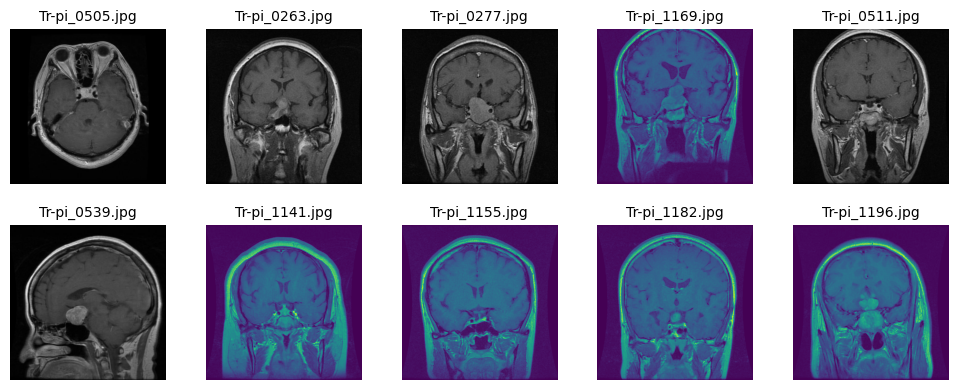

In [61]:
# Directory: ./data/original/Training/pituitary images
tr_pituitary_dir = "./data/original/Training/pituitary/"
tr_pituitary_files = data_overview(tr_pituitary_dir)

Pituitary tumors arise from the pituitary gland, a small gland located at the base of the brain. On imaging scans, pituitary tumors may appear as well-defined, round or lobulated masses within the sella turcica, a bony cavity where the pituitary gland resides. In the images above, we see the tumors generally surround that explained area; to understand this region further, please look below. These tumors can cause enlargement of the sella turcica and may extend into adjacent structures such as the cavernous sinuses or optic chiasm.

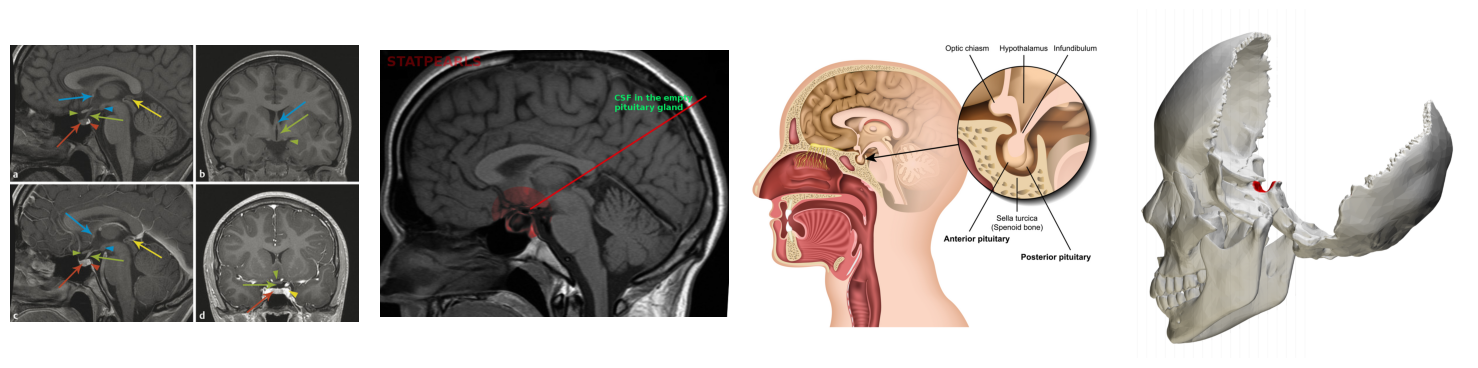

In [69]:
pituitary1 = Image.open("./pituitary examples/10-1055-b-004-135649_c013_f001ad.jpg")
pituitary2 = Image.open("./pituitary examples/Empty__sella__syndrome.jpg")
pituitary3 = Image.open("./pituitary examples/pituitary-gland-anatomy.jpg")
pituitary4 = Image.open("./pituitary examples/Sella_turcica08.png")

# Create a figure and axis objects
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot images on separate axes
axes[0].imshow(pituitary1)
axes[0].axis("off")

axes[1].imshow(pituitary2)
axes[1].axis("off")

axes[2].imshow(pituitary3)
axes[2].axis("off")

axes[3].imshow(pituitary4)
axes[3].axis("off")

plt.tight_layout()
plt.show()

In [62]:
tr_pituitary_modes = check_image_mode(tr_pituitary_files, tr_pituitary_dir)
tr_pituitary_rgb_images = [img["file"] for img in tr_pituitary_modes if img["mode"] == "RGB"]
print(tr_pituitary_rgb_images)

['Tr-pi_0505.jpg', 'Tr-pi_0263.jpg', 'Tr-pi_0277.jpg', 'Tr-pi_0511.jpg', 'Tr-pi_0539.jpg', 'Tr-pi_0288.jpg', 'Tr-pi_0061.jpg', 'Tr-pi_0707.jpg', 'Tr-pi_0713.jpg', 'Tr-pi_0075.jpg', 'Tr-pi_0049.jpg', 'Tr-pi_0115.jpg', 'Tr-pi_0673.jpg', 'Tr-pi_0667.jpg', 'Tr-pi_0101.jpg', 'Tr-pi_0129.jpg', 'Tr-pi_0698.jpg', 'Tr-pi_0471.jpg', 'Tr-pi_0317.jpg', 'Tr-pi_0303.jpg', 'Tr-pi_0465.jpg', 'Tr-pi_0459.jpg', 'Tr-pi_0458.jpg', 'Tr-pi_0302.jpg', 'Tr-pi_0464.jpg', 'Tr-pi_0470.jpg', 'Tr-pi_0316.jpg', 'Tr-pi_0699.jpg', 'Tr-pi_0128.jpg', 'Tr-pi_0666.jpg', 'Tr-pi_0100.jpg', 'Tr-pi_0114.jpg', 'Tr-pi_0672.jpg', 'Tr-pi_0048.jpg', 'Tr-pi_0712.jpg', 'Tr-pi_0074.jpg', 'Tr-pi_0060.jpg', 'Tr-pi_0706.jpg', 'Tr-pi_0289.jpg', 'Tr-pi_0538.jpg', 'Tr-pi_0276.jpg', 'Tr-pi_0510.jpg', 'Tr-pi_0504.jpg', 'Tr-pi_0262.jpg', 'Tr-pi_0512.jpg', 'Tr-pi_0274.jpg', 'Tr-pi_0260.jpg', 'Tr-pi_0506.jpg', 'Tr-pi_0248.jpg', 'Tr-pi_0076.jpg', 'Tr-pi_0710.jpg', 'Tr-pi_0704.jpg', 'Tr-pi_0062.jpg', 'Tr-pi_0738.jpg', 'Tr-pi_0089.jpg', 'Tr-pi_01

In [63]:
tr_pituitary_grayscale_images = [img["file"] for img in tr_pituitary_modes if img["mode"] != "RGB"]
print(tr_pituitary_grayscale_images)

['Tr-pi_1169.jpg', 'Tr-pi_1141.jpg', 'Tr-pi_1155.jpg', 'Tr-pi_1182.jpg', 'Tr-pi_1196.jpg', 'Tr-pi_1419.jpg', 'Tr-pi_1343.jpg', 'Tr-pi_1425.jpg', 'Tr-pi_1431.jpg', 'Tr-pi_1357.jpg', 'Tr-pi_0908.jpg', 'Tr-pi_1380.jpg', 'Tr-pi_0920.jpg', 'Tr-pi_0934.jpg', 'Tr-pi_1394.jpg', 'Tr-pi_1237.jpg', 'Tr-pi_0897.jpg', 'Tr-pi_0883.jpg', 'Tr-pi_1223.jpg', 'Tr-pi_0868.jpg', 'Tr-pi_0854.jpg', 'Tr-pi_0840.jpg', 'Tr-pi_1009.jpg', 'Tr-pi_1035.jpg', 'Tr-pi_1021.jpg', 'Tr-pi_1020.jpg', 'Tr-pi_1034.jpg', 'Tr-pi_1008.jpg', 'Tr-pi_0841.jpg', 'Tr-pi_0855.jpg', 'Tr-pi_0869.jpg', 'Tr-pi_0882.jpg', 'Tr-pi_1222.jpg', 'Tr-pi_1236.jpg', 'Tr-pi_0896.jpg', 'Tr-pi_0935.jpg', 'Tr-pi_1395.jpg', 'Tr-pi_1381.jpg', 'Tr-pi_0921.jpg', 'Tr-pi_0909.jpg', 'Tr-pi_1430.jpg', 'Tr-pi_1356.jpg', 'Tr-pi_1342.jpg', 'Tr-pi_1424.jpg', 'Tr-pi_1418.jpg', 'Tr-pi_1197.jpg', 'Tr-pi_1183.jpg', 'Tr-pi_1154.jpg', 'Tr-pi_1140.jpg', 'Tr-pi_1168.jpg', 'Tr-pi_1156.jpg', 'Tr-pi_1142.jpg', 'Tr-pi_1195.jpg', 'Tr-pi_1181.jpg', 'Tr-pi_1368.jpg', 'Tr-pi_13

In [64]:
tr_pituitary_valid_imgs = validify(tr_pituitary_files, tr_pituitary_dir)
tr_pituitary_outliers = find_outliers(tr_pituitary_files, tr_pituitary_dir)
print("Outliers based on size:", tr_pituitary_outliers)

Outliers based on size: ['Tr-pi_1394.jpg', 'Tr-pi_1394.jpg', 'Tr-pi_0854.jpg', 'Tr-pi_0854.jpg', 'Tr-pi_1356.jpg', 'Tr-pi_1356.jpg', 'Tr-pi_0857.jpg', 'Tr-pi_0857.jpg', 'Tr-pi_0856.jpg', 'Tr-pi_0856.jpg', 'Tr-pi_0729.jpg', 'Tr-pi_0729.jpg', 'Tr-pi_1386.jpg', 'Tr-pi_1386.jpg', 'Tr-pi_0853.jpg', 'Tr-pi_0853.jpg', 'Tr-pi_0943.jpg', 'Tr-pi_0943.jpg', 'Tr-pi_0361.jpg', 'Tr-pi_0361.jpg', 'Tr-pi_0942.jpg', 'Tr-pi_0942.jpg', 'Tr-pi_0363.jpg', 'Tr-pi_0363.jpg', 'Tr-pi_0362.jpg', 'Tr-pi_0362.jpg', 'Tr-pi_0038.jpg', 'Tr-pi_0038.jpg', 'Tr-pi_0365.jpg', 'Tr-pi_0365.jpg', 'Tr-pi_0364.jpg', 'Tr-pi_0364.jpg', 'Tr-pi_0037.jpg', 'Tr-pi_0037.jpg', 'Tr-pi_0432.jpg', 'Tr-pi_0432.jpg', 'Tr-pi_0036.jpg', 'Tr-pi_0431.jpg', 'Tr-pi_0431.jpg', 'Tr-pi_0031.jpg', 'Tr-pi_0031.jpg', 'Tr-pi_0435.jpg', 'Tr-pi_0435.jpg', 'Tr-pi_0434.jpg', 'Tr-pi_0434.jpg', 'Tr-pi_0030.jpg', 'Tr-pi_0030.jpg', 'Tr-pi_0032.jpg', 'Tr-pi_0032.jpg', 'Tr-pi_0436.jpg', 'Tr-pi_0436.jpg', 'Tr-pi_0041.jpg', 'Tr-pi_0041.jpg', 'Tr-pi_0042.jpg', 'Tr

Similar to what we did previously, we removed the outlying files -- the number was reduced from 1457 to 1424.

In [66]:
tr_pituitary_files = [file for file in tr_pituitary_files if file not in tr_pituitary_outliers]
len(tr_pituitary_files)

1424

## Class Distribution in Dataset

In [34]:
tr_dir= './data/original/Training'
ts_dir = './data/original/Testing'

In [35]:
tr_paths = []
tr_labels = []
ts_paths = []
ts_labels = []

In [36]:
for label in os.listdir(tr_dir):
    # Ignore .DS_Store file if present
    if label == '.DS_Store':
        continue

    # Check if the path is a directory
    label_path = os.path.join(tr_dir, label)
    if not os.path.isdir(label_path):
        continue
    
    for image in os.listdir(tr_dir+"/"+label):
        tr_paths.append(tr_dir+"/"+label+"/"+image)
        tr_labels.append(label)

random.shuffle(tr_paths)
random.shuffle(tr_labels)

In [37]:
for label in os.listdir(ts_dir):
    # Ignore .DS_Store file if present
    if label == '.DS_Store':
        continue

    # Check if the path is a directory
    label_path = os.path.join(ts_dir, label)
    if not os.path.isdir(label_path):
        continue
    
    for image in os.listdir(ts_dir+"/"+label):
        ts_paths.append(ts_dir+"/"+label+"/"+image)
        ts_labels.append(label)

random.shuffle(ts_paths)
random.shuffle(ts_labels)

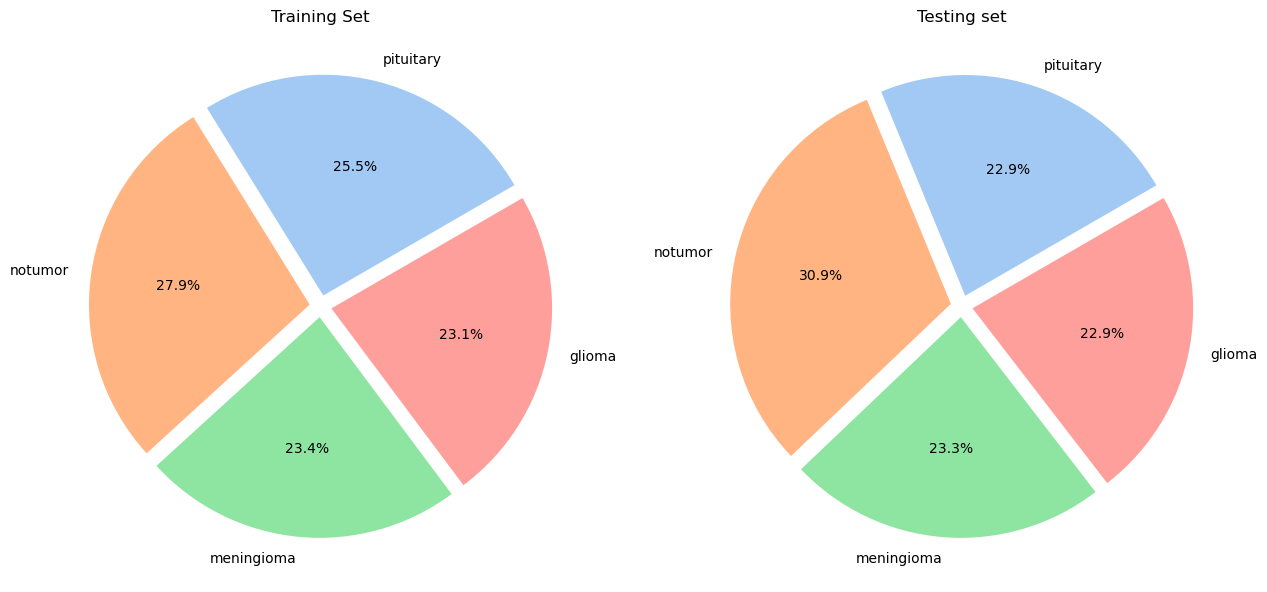

In [38]:
plt.figure(figsize=(13,6))
color = sns.color_palette('pastel')
plt.rcParams.update({'font.size': 10})

plt.subplot(1, 2, 1)
plt.pie([len([x for x in tr_labels if x=='pituitary']),
         len([x for x in tr_labels if x=='notumor']),
         len([x for x in tr_labels if x=='meningioma']),
         len([x for x in tr_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=color, autopct='%.1f%%', explode=(0.05, 0.05, 0.05, 0.05),
        startangle=30)
plt.title('Training Set')

plt.subplot(1, 2, 2)
plt.pie([len([x for x in ts_labels if x=='pituitary']),
         len([x for x in ts_labels if x=='notumor']),
         len([x for x in ts_labels if x=='meningioma']),
         len([x for x in ts_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=color, autopct='%.1f%%', explode=(0.05, 0.05, 0.05, 0.05),
        startangle=30)
plt.title('Testing set')

plt.tight_layout()
plt.show()

The provided statistics above indicate a balanced dataset. The distribution of classes is relatively uniform across the training and testing sets. In the training set, the percentages range from 23.1% to 27.9% and in the testing set, the percentages range from 22.9% to 30.9%; these percentages and ranges are very close to one another. In addition, each class occupies a similar proportion of the dataset, with no specific label dominating over the others. The small differences in percentages between classes indicate low variability in class distribution. This consistency will provide certain benefits when we create our model:
- **Avoiding Skewed Results:** In imbalanced datasets, models tend to perform well on the majority class but poorly on minority classes. Balanced datasets mitigate this issue, ensuring that the model's performance is not skewed towards any particular class.
- **Reduced Overfitting:** Models trained on imbalanced datasets may overfit to the majority class and generalize poorly to new data. Balanced datasets reduce the risk of overfitting by providing more representative samples of all classes.
- **Improved Decision Making:** In real-world applications, all classes are typically of interest. Having a balanced dataset ensures that the model can make reliable predictions for all classes, enabling better decision-making.
- **Interpretability:** Balanced datasets make it easier to interpret the model's performance metrics, such as accuracy, precision, recall, and F1-score, as they reflect the model's ability to classify all classes equally well.

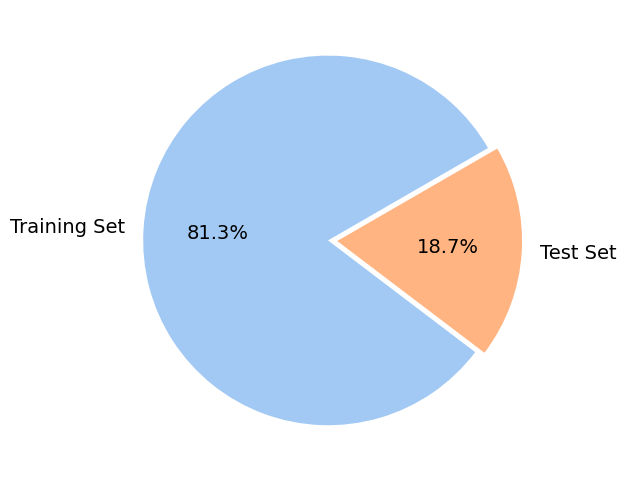

In [51]:
plt.figure(figsize=(14,6))
plt.rcParams.update({'font.size': 14})
plt.pie([len(tr_labels), len(ts_labels)],
        labels=['Training Set','Test Set'],
        colors=color, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

This distribution where the training set constitutes 81.3% of the total data, while the testing set accounts for 18.7%, should be considered good. Please refer to the following reasons I have listed below:
- **Training Set Size:** Having a larger training set compared to the testing set is generally beneficial. A larger training set allows your model to learn more effectively from the data, capture complex patterns, and generalize better to unseen examples during testing. Therefore, having 81.3% of the data allocated to the training set provides ample data for training your model.
- **Testing Set Size:** While the testing set is smaller compared to the training set, allocating 18.7% of the data to testing is still substantial, especially if your dataset is large. A sufficiently sized testing set ensures that you can evaluate your model's performance robustly and obtain reliable estimates of its generalization ability.
- **Imbalance Concerns:** The imbalance between the training and testing sets (81.3% vs. 18.7%) is not necessarily a concern as long as both sets are representative of the underlying data distribution. However, it's essential to ensure that the testing set contains a diverse range of examples that cover the various classes or scenarios present in the dataset.
- **Cross-Validation:** To further assess the performance of your model and mitigate the effects of data partitioning, you can employ techniques such as k-fold cross-validation. Cross-validation allows you to train and evaluate your model multiple times on different subsets of the data, providing a more comprehensive assessment of its performance.